# Lab Solution Notebook - Lecture 12

This notebook provides an introduction to evaluating the fairness of your predictive model. This is especially relevant because in modeling human data, treating different socio-demographic groups equitably is especially important. It is also crucial to consider the context of your downstream task and where these predictions will be used.

In this lab, we will investigate **5 different metrics** to measure model fairness:
- equal opportunity
- equalized odds
- disparate impact
- demographic parity
- predictive rate parity

The material for this notebook is inspired by a [Towards Data Science ML fairness tutorial](https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705) by Conor O'Sullivan.

You have already seen three of these metrics in the lecture exploration on flipped classroom data collected at EPFL. In this lab, you will:
- learn about 2 more fairness metrics **(equal opportunity** and **disparate impact)**
- explore a full fairness analysis on a sensitive attribute **Country (Diploma)**
- explore a combined fairness analysis on subgroups involving both **Gender** and **Country (Diploma)**

**Gender** refers to the gender of the student (M for male, F for female, or non-specified), and **Country (Diploma)** represents the country the student completed their diploma from (France, Suisse, or non-specified).

In [1]:
# Load standard imports for the rest of the notebook.
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

DATA_DIR = "./../../data/"

## Loading the Data

In [2]:
# Load demographic data. The two attributes that are relevant to our analysis are "country_diploma" and "gender",
# although there are many other analyses that can be conducted.

demographics = pd.read_csv(DATA_DIR + 'demographics.csv', index_col=0).reset_index()
demographics

,index,gender,country_diploma,continent_diploma,year_diploma,title_diploma,avg_french_bac,rating_french,scale_french,rating_maths,scale_maths,rating_physics,scale_physics,grade
0,0,M,France,Europe,2018.0,Bacc. étranger,18.28,15.0,20.0,17.0,20.0,19.0,20,2.50
1,1,M,France,Europe,2018.0,Bacc. étranger,17.68,13.0,20.0,18.0,20.0,19.0,20,1.75
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
3,3,M,France,Europe,2018.0,Bacc. étranger,17.78,11.0,20.0,20.0,20.0,19.0,20,4.50
4,4,M,France,Europe,2018.0,Bacc. étranger,18.84,13.0,20.0,19.0,20.0,20.0,20,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,105,M,France,Europe,2018.0,Bacc. étranger,14.76,16.0,20.0,14.0,20.0,15.0,20.0,2.75
210,106,M,Suisse,Europe,2019.0,Mat. reconnue opt. physique et math,NaN,4.5,6.0,6.0,6.0,5.5,6.0,3.25
211,107,M,Suisse,Europe,2018.0,Mat. reconnue opt. physique et math,NaN,5.5,6.0,5.5,6.0,5.5,6.0,5.75
212,108,M,France,Europe,2018.0,Bacc. étranger,17.21,12.0,20.0,17.0,20.0,18.0,20.0,5.50


In [3]:
demographics['country_diploma'].unique()

array(['France', nan, 'Suisse'], dtype=object)

In [4]:
# We've run a BiLSTM model on the data using a 10-fold cross validation, generating predictions for all 214 students.
predictions = pd.read_csv(DATA_DIR + 'model_predictions.csv')

# convert predictions between [0, 1] to binary variable for pass / fail {0, 1}
y_pred = [1 if grade < 0.5 else 0 for grade in predictions['grade']]

In [5]:
# Load and process ground truth grades, which are between 0 to 6
# Recieving a score 4 or higher is passing, so we can convert these grades to a binary pass/fail variable {0, 1}
y = [1 if grade >= 4 else 0 for grade in demographics['grade']]

In [6]:
demographics.insert(0, 'y', y)
demographics.insert(1, 'y_pred', y_pred)

#### Number of data in each caterogies

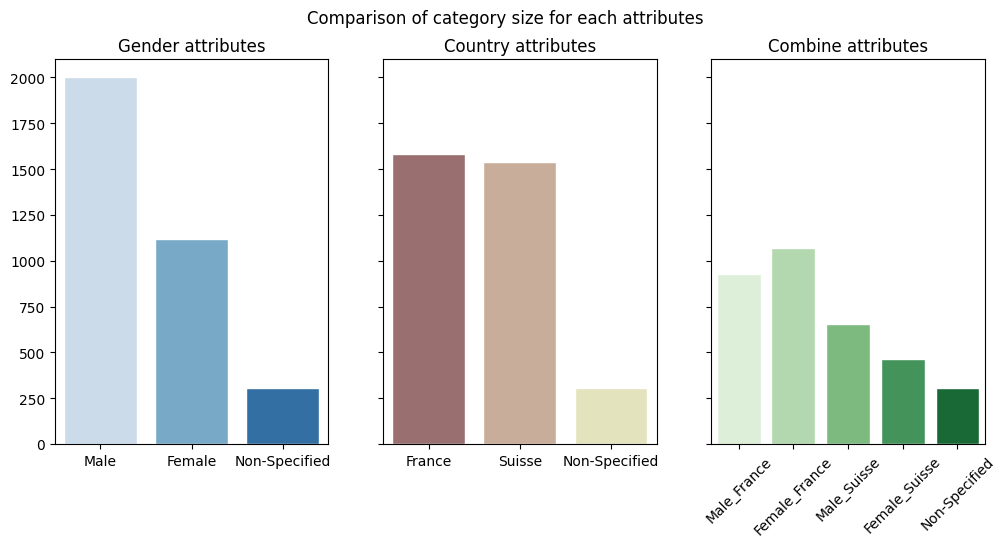

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

M_size = demographics[demographics['gender'] == 'M'].size
F_size = demographics[demographics['gender'] == 'F'].size

France_size = demographics[demographics['country_diploma'] == 'France'].size
Suisse_size = demographics[demographics['country_diploma'] == 'Suisse'].size

France_M_size = demographics[(demographics['country_diploma'] == 'France') & 
                                        (demographics['gender'] == 'M')].size
Suisse_M_size = demographics[(demographics['country_diploma'] == 'Suisse') & 
                                        (demographics['gender'] == 'M')].size
France_F_size = demographics[(demographics['country_diploma'] == 'France') & 
                                        (demographics['gender'] == 'F')].size
Suisse_F_size = demographics[(demographics['country_diploma'] == 'Suisse') & 
                                        (demographics['gender'] == 'F')].size

none_size = demographics[(demographics['country_diploma'].isna())].size

gender_cat = ['Male', 'Female', 'Non-Specified']
sns.barplot(x=gender_cat, y=[M_size, F_size, none_size], palette = 'Blues', edgecolor = 'w', ax=axs[0])
axs[0].set_title("Gender attributes")

country_cat = ['France', 'Suisse', 'Non-Specified']
sns.barplot(x=country_cat, y=[France_size, Suisse_size, none_size], palette = 'pink', edgecolor = 'w', ax=axs[1])
axs[1].set_title("Country attributes")

gender_country_cat = ['Male_France', 'Female_France', 'Male_Suisse', 'Female_Suisse', 'Non-Specified']
sns.barplot(x=gender_country_cat, y=[France_M_size, Suisse_M_size, France_F_size, Suisse_F_size, none_size], palette = 'Greens', edgecolor = 'w', ax=axs[2])
axs[2].set_title("Combined Attributes")

fig.suptitle("Comparison of category size for each attributes")
plt.xticks(rotation=45)
plt.show()

## Measuring Fairness

Now, we will move into analyzing methods to measure fairness.

Accuracy is not an ideal measure of fairness. We can base the accuracy calculation on the confusion matrix below. This is a standard confusion matrix used to compare model predictions to the actual target variable. Here Y=1 is a positive prediction (student passes the course) and Y=0 is a negative prediction (student fails the course). We will also be referring back to this matrix when we calculate the other fairness metrics.

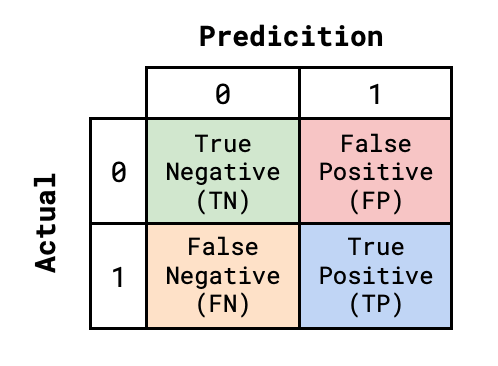

We can use the confusion matrix to calculate accuracy. Accuracy is the number of true negatives and true positives over the total number of observations. In other words, accuracy is the percentage of correct predictions.

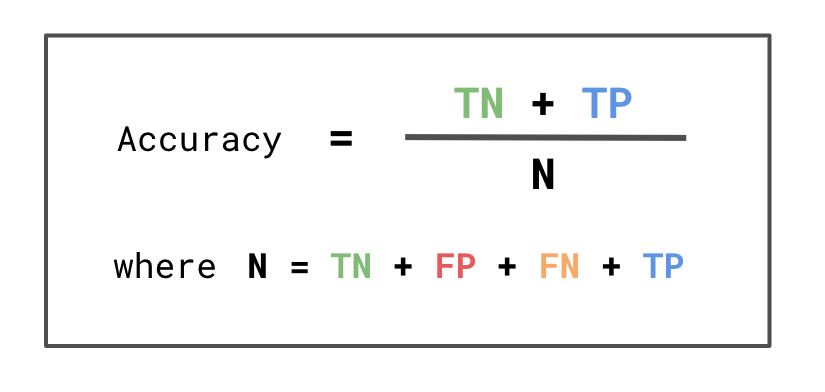

In [8]:
def accuracy(df):
    """Calculate accuracy through the confusion matrix."""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Total population
    N = TP + FP + FN + TN 
    
    # Accuracy
    ACC = (TP + TN) / N 
    
    return ACC

In [9]:
print("Overall Accuracy:", np.round(accuracy(demographics), 3))

Overall Accuracy: 0.724


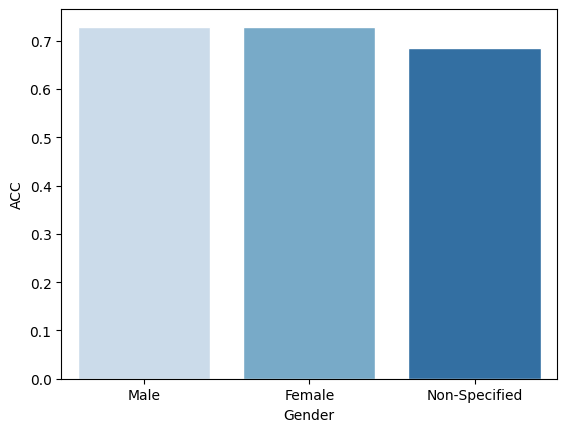

In [10]:
gender_df = pd.DataFrame()
gender_df['Gender'] = ['Male', 'Female', 'Non-Specified']
gender_df['ACC'] = [np.round(accuracy(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(accuracy(demographics[demographics['gender'] == 'F']), 3),
                    np.round(accuracy(demographics[demographics['gender'].isna()]), 3)]

       
sns.barplot(x='Gender', y='ACC', data=gender_df, palette = 'Blues', edgecolor = 'w')
plt.show()

We can see that Male and Female have the same accuracy. The accuracy seems to not depend on the gender.

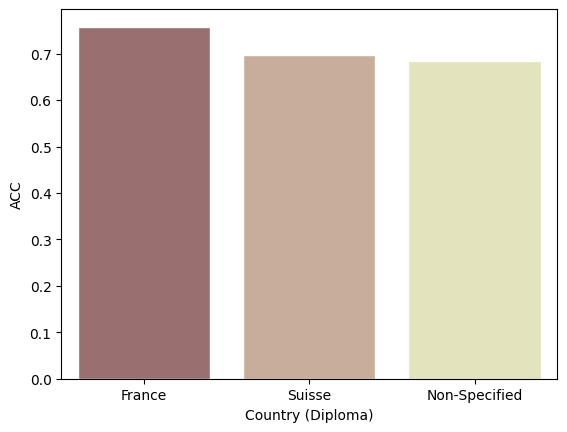

In [11]:
country_df = pd.DataFrame()
country_df['Country (Diploma)'] = ['France', 'Suisse', 'Non-Specified']
country_df['ACC'] = [np.round(accuracy(demographics[demographics['country_diploma'] == 'France']), 3), 
                    np.round(accuracy(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                    np.round(accuracy(demographics[demographics['country_diploma'].isna()]), 3)]

       
sns.barplot(x='Country (Diploma)', y='ACC', data=country_df, palette = 'pink', edgecolor = 'w')
plt.show()

We see a slightly better accuracy when predicting student from France than from Switzerland.

#### Combined Attributes

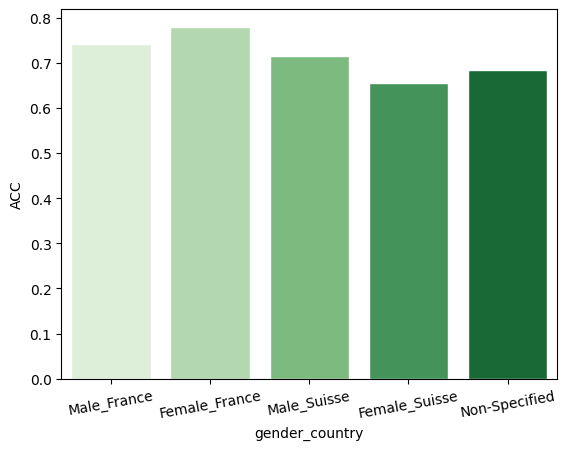

In [12]:
combined_df = pd.DataFrame()
combined_df["gender_country"] = ['Male_France', 'Female_France', 'Male_Suisse', 'Female_Suisse', 'Non-Specified']

combined_df['ACC'] = [
                    np.round(accuracy(demographics[(demographics['country_diploma'] == 'France') & 
                                                    (demographics['gender'] == 'M')]), 3), 
                    np.round(accuracy(demographics[(demographics['country_diploma'] == 'France') & 
                                                    (demographics['gender'] == 'F')]), 3), 
                    np.round(accuracy(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                    (demographics['gender'] == 'M')]), 3), 
                    np.round(accuracy(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                    (demographics['gender'] == 'F')]), 3), 
                    np.round(accuracy(demographics[demographics['country_diploma'].isna()]), 3), 
                    ]

sns.barplot(x='gender_country', y='ACC', data=combined_df, palette = 'Greens', edgecolor = 'w')
plt.xticks(rotation = 10)
plt.show()

Interestingly, male from France and Switzerland have similar accuracy, but concerning Female, the difference is more significante. Neverless, as expected from the previous graph, Male and Female from France have both better accuracy than their corresponding category in Switzerland.

## Fairness Definition 1: Equal opportunity

To better capture the benefits of a model we can use the true positive rate (TPR). You can see how we calculate TPR below. The denominator is the number of actual positives. The numerator is the number of correctly predicted positives. In other words, TPR is the percentage of actual positives that were correctly predicted as positive.

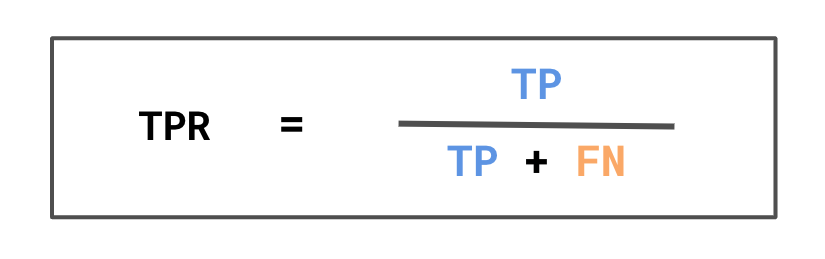

Under **equal opportunity** we consider a model to be fair if the TPRs of the privileged and unprivileged groups are equal. In practice, we will give some leeway for statistic uncertainty. We can require the differences to be less than a certain cutoff (Equation 2). For our analysis, we have taken the ratio. In this case, we require the ratio to be larger than some cutoff (Equation 3). This ensures that the TPR for the unprivileged group is not significantly smaller than for the privileged group.

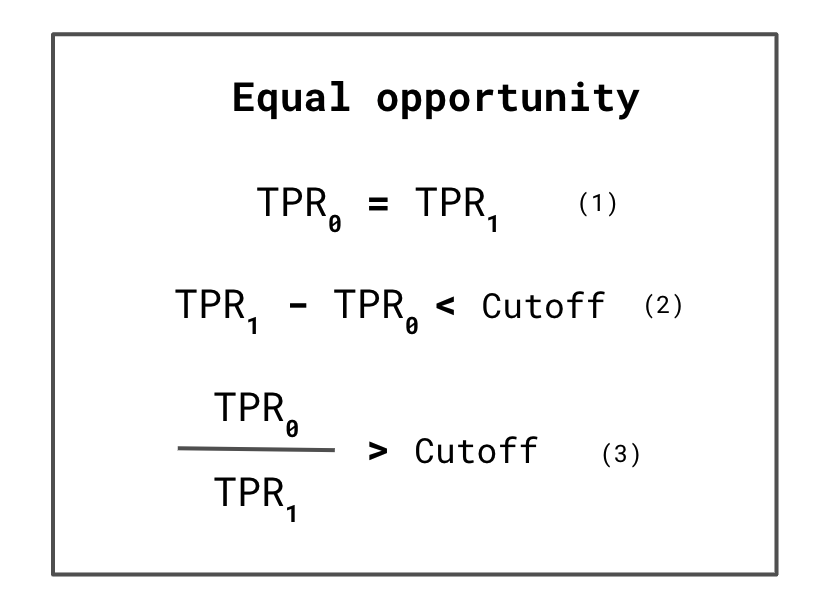

In [13]:
def true_positive_rate(df):
    """Calculate equal opportunity (true positive rate)."""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Total population
    N = TP + FP + FN + TN 
    
    # True positive rate
    TPR = TP / (TP + FN) 
    
    return TPR 

In [14]:
print("Overall Equal Opportunity:", np.round(true_positive_rate(demographics), 3))

Overall Equal Opportunity: 0.791


#### Sensitive Attribute: Gender

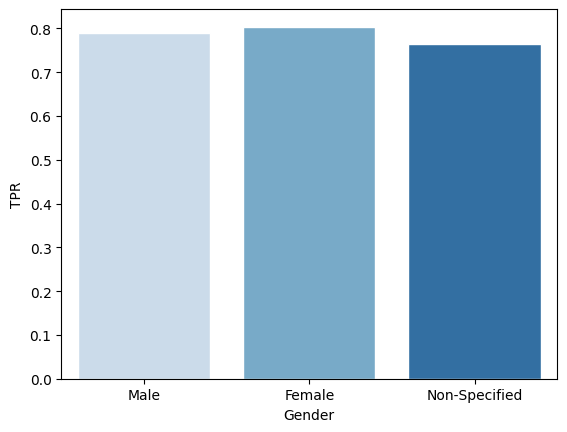

In [15]:
gender_df['TPR'] = [np.round(true_positive_rate(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(true_positive_rate(demographics[demographics['gender'] == 'F']), 3),
                    np.round(true_positive_rate(demographics[demographics['gender'].isna()]), 3)]

sns.barplot(x='Gender', y='TPR', data=gender_df, palette = 'Blues', edgecolor = 'w')
plt.show()

In [16]:
# For equal opportunity, we directly compare the difference between TPRs of the sensitive attributes. 
# We define our significance cutoff at 0.1, stating any difference below 10% can be attributed to random chance.

def stats_eq_opp(df, attr, stat='TPR', cutoff=0.1, indexs=[0, 1]):
    TPR_0, TPR_1 = df[stat][indexs[0]], df[stat][indexs[1]]
    equal_opp = np.abs(np.round(TPR_1 - TPR_0, 3))
    equal_opp_ratio = np.round(np.minimum(TPR_0, TPR_1) / np.maximum(TPR_0, TPR_1), 3)
    
    print('Sensitive Attr:', attr, '\n')
    
    print('------------------------------------')
    print('|Equal Opportunity| < Cutoff?', np.abs(equal_opp) > cutoff)
    print('------------------------------------')
    print('TPR0 (', df[attr][indexs[0]], ') =', TPR_0)
    print('TPR1 (', df[attr][indexs[1]], ') =', TPR_1)
    print('Equal Opportunity:', equal_opp)
    print('Cutoff:', cutoff)


    print('\n------------------------------------')
    print('Equal Opportunity Ratio?', equal_opp_ratio)
    print('------------------------------------')

stats_eq_opp(gender_df, 'Gender')

Sensitive Attr: Gender 

------------------------------------
|Equal Opportunity| < Cutoff? False
------------------------------------
TPR0 ( Male ) = 0.789
TPR1 ( Female ) = 0.804
Equal Opportunity: 0.015
Cutoff: 0.1

------------------------------------
Equal Opportunity Ratio? 0.981
------------------------------------


We have an Equal Opportunity is smaller than the Cutoff, hence we consider our model as fair. Also the Equal Opportunity Ratio is bigger than the Cutoff and close to 1, meaning that there is no unpriviledge group.

#### Sensitive Attribute: Country 

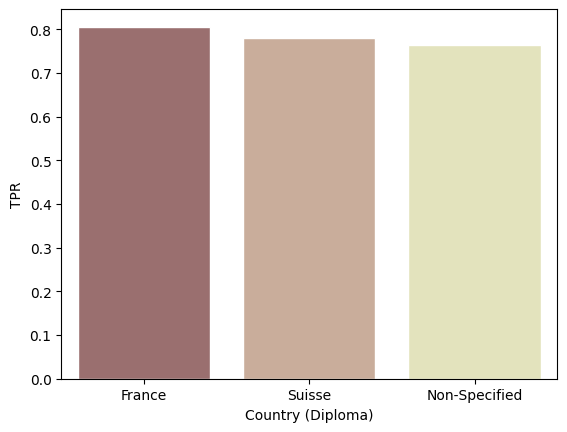

In [17]:
country_df['TPR'] = [np.round(true_positive_rate(demographics[demographics['country_diploma'] == 'France']), 3), 
                    np.round(true_positive_rate(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                    np.round(true_positive_rate(demographics[demographics['country_diploma'].isna()]), 3)]

       
sns.barplot(x='Country (Diploma)', y='TPR', data=country_df, palette = 'pink', edgecolor = 'w')
plt.show()

In [18]:
stats_eq_opp(country_df, 'Country (Diploma)')

Sensitive Attr: Country (Diploma) 

------------------------------------
|Equal Opportunity| < Cutoff? False
------------------------------------
TPR0 ( France ) = 0.806
TPR1 ( Suisse ) = 0.78
Equal Opportunity: 0.026
Cutoff: 0.1

------------------------------------
Equal Opportunity Ratio? 0.968
------------------------------------


We have an Equal Opportunity is smaller than the Cutoff, hence we consider our model as fair. Also the Equal Opportunity Ratio is bigger than the Cutoff and close to 1, meaning that there is no unpriviledge group.

#### Combined Attributes

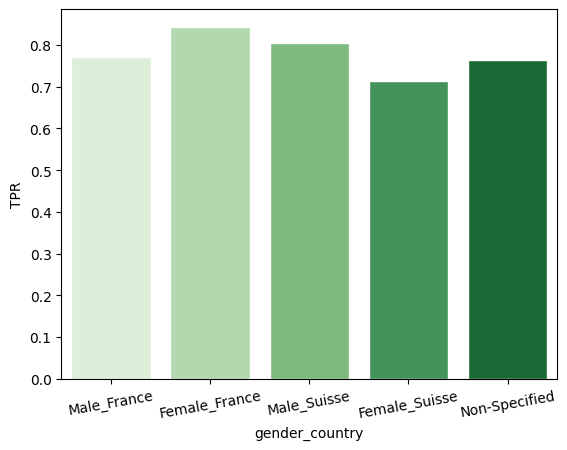

In [19]:
combined_df['TPR'] = [
                    np.round(true_positive_rate(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'M')]), 3), 
                    np.round(true_positive_rate(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'F')]), 3), 
                    np.round(true_positive_rate(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'M')]), 3), 
                    np.round(true_positive_rate(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'F')]), 3), 
                    np.round(true_positive_rate(demographics[demographics['country_diploma'].isna()]), 3), 
                    ]

sns.barplot(x='gender_country', y='TPR', data=combined_df, palette = 'Greens', edgecolor = 'w')
plt.xticks(rotation = 10)
plt.show()

In [20]:
def get_heatmap(df, attr, func, stat='TPR', cutoff=0.1):
    size = df[attr].size
    data = df[stat]
    heatmap = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            heatmap[i, j] = func([data[i], data[j]])
    
    return heatmap

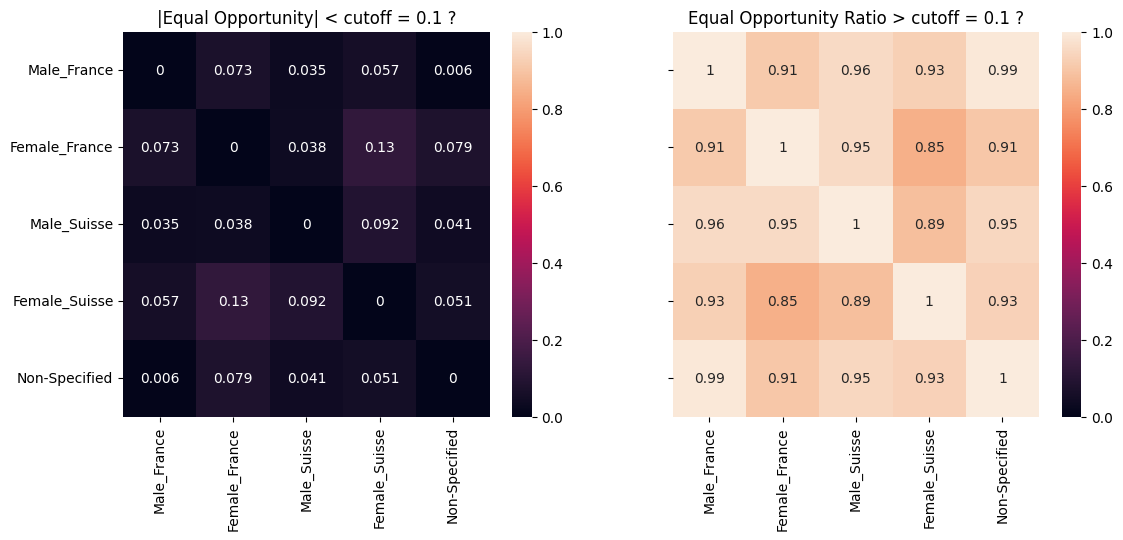

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3))
sns.heatmap(heatmap, ax=ax[0], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[0].set_title("|Equal Opportunity| < cutoff = 0.1 ?")

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.minimum(x[0], x[1]) / np.maximum(x[0], x[1]), 3))
sns.heatmap(heatmap, ax=ax[1], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[1].set_title("Equal Opportunity Ratio > cutoff = 0.1 ?")

plt.show()

### False negative rate (FNR)

In some cases, you may want to capture the negative consequences of a model. In FNR, the denominator gives the number of actual positives. Except now we have the number of incorrectly predicted negatives as the numerator. In other words, the FNR is the percentage of actual positives incorrectly predicted as negative.

The FNR can be interpreted as the percentage of people who have wrongfully not benefitted from the model.

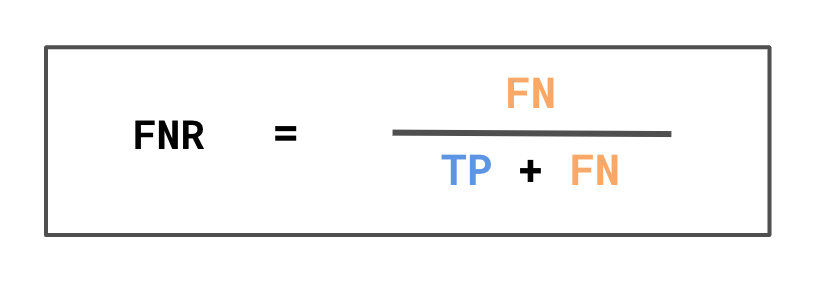

In [22]:
def false_negative_rate(df):
    """Calculate false negative rate"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    # False negative rate
    FNR = FN / (TP + FN) 
  
    return FNR

In [23]:
print("Overall FNR:", np.round(false_negative_rate(demographics), 3))

Overall FNR: 0.209


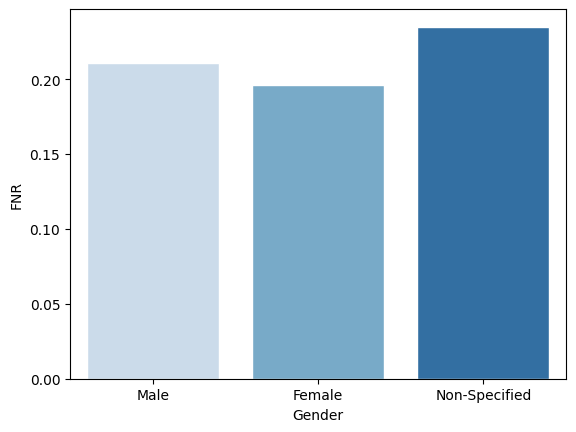

In [24]:
gender_df['FNR'] = [np.round(false_negative_rate(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(false_negative_rate(demographics[demographics['gender'] == 'F']), 3),
                    np.round(false_negative_rate(demographics[demographics['gender'].isna()]), 3)]
       
sns.barplot(x='Gender', y='FNR', data=gender_df, palette = 'Blues', edgecolor = 'w')
plt.show()

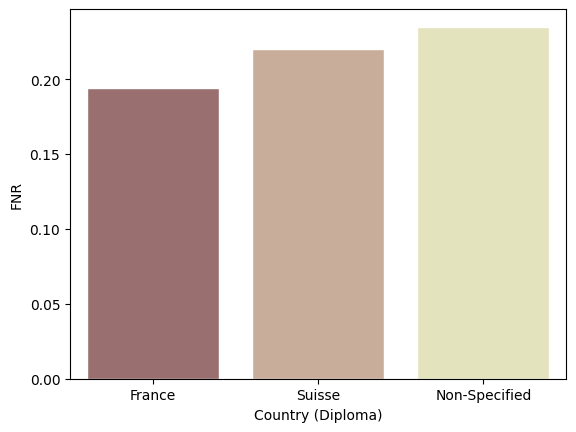

In [25]:
country_df['FNR'] = [np.round(false_negative_rate(demographics[demographics['country_diploma'] == 'France']), 3), 
                    np.round(false_negative_rate(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                    np.round(false_negative_rate(demographics[demographics['country_diploma'].isna()]), 3)]

       
sns.barplot(x='Country (Diploma)', y='FNR', data=country_df, palette = 'pink', edgecolor = 'w')
plt.show()

#### Combined Attributes

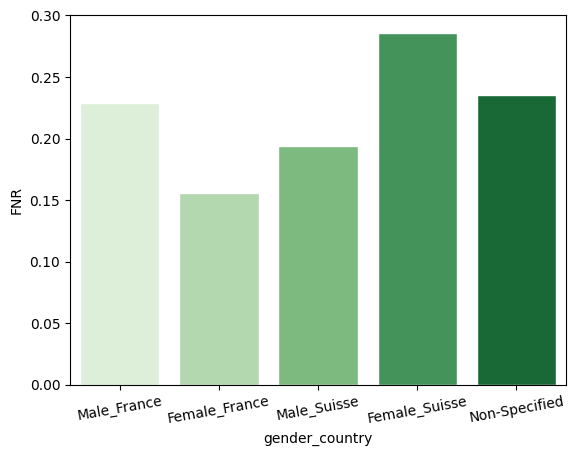

In [26]:
combined_df['FNR'] = [
                    np.round(false_negative_rate(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'M')]), 3), 
                    np.round(false_negative_rate(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'F')]), 3), 
                    np.round(false_negative_rate(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'M')]), 3), 
                    np.round(false_negative_rate(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'F')]), 3), 
                    np.round(false_negative_rate(demographics[demographics['country_diploma'].isna()]), 3), 
                    ]

sns.barplot(x='gender_country', y='FNR', data=combined_df, palette = 'Greens', edgecolor = 'w')
plt.xticks(rotation = 10)
plt.show()

## Fairness Definition 2: Equalized Odds

Another way we can capture the benefits of a model is by looking at false positive rates (FPR). As seen in Figure 10, the denominator is the number of actual negatives. This means the TPR is the percentage of actual negatives incorrectly predicted as positive. This can be interpreted as the percentage of people who have wrongfully benefited from the model.

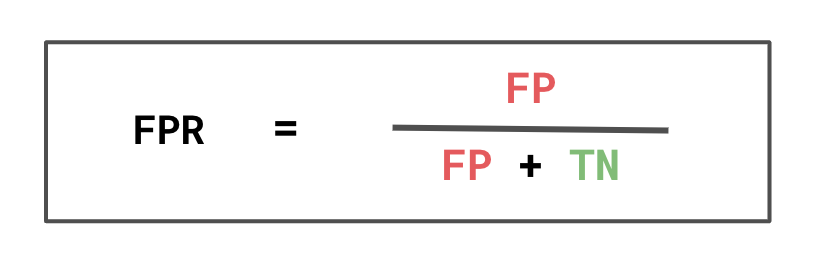


This leads us to the second definition of fairness, **equalized odds**. Like with equal opportunity, this definition requires that the TPRs are equal. Now we also require that the FPRs are equal. This means equalized odds can be thought of as a stricter definition of fairness. It also makes sense that for a model to be fair overall benefit should be equal. That is a similar percentage of the groups should both rightfully and wrongfully benefit.

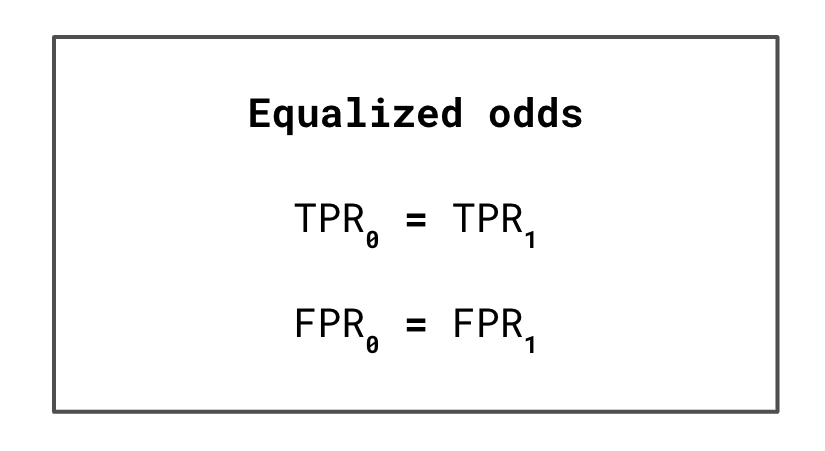

An advantage of equalized odds is that it does not matter how we define our target variable. Suppose instead we had Y = 0 leads to a benefit. In this case the interpretations of TPR and FPR swap. TPR now captures the wrongful benefit and FPR now captures the rightful benefit. Equalized odds already uses both of these rates so the interpretation remains the same. In comparison, the interpretation of equal opportunity changes as it only considers TPR.

In [27]:
def equalized_odds(df):
    """Calculate FPR and TPR for subgroup of population"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel() 
    
    # True positive rate
    TPR = TP / (TP + FN) 
    
    # False positive rate
    FPR = FP / (FP + TN)
    
    return [TPR, FPR]

In [28]:
equal_odds = equalized_odds(demographics)
print("Overall TPR:", np.round(equal_odds[0], 3))
print("Overall FPR:", np.round(equal_odds[1], 3))

Overall TPR: 0.791
Overall FPR: 0.388


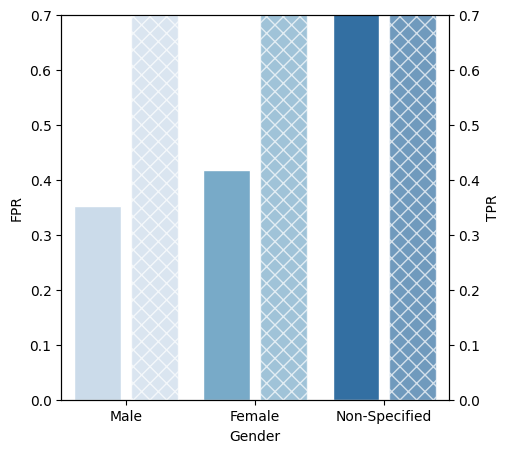

In [29]:
gender_df['TPR'] = [np.round(equalized_odds(demographics[demographics['gender'] == 'M'])[0], 3), 
                    np.round(equalized_odds(demographics[demographics['gender'] == 'F'])[0], 3),
                    np.round(equalized_odds(demographics[demographics['gender'].isna()])[0], 3)]

gender_df['FPR'] = [np.round(equalized_odds(demographics[demographics['gender'] == 'M'])[1], 3), 
                    np.round(equalized_odds(demographics[demographics['gender'] == 'F'])[1], 3),
                    np.round(equalized_odds(demographics[demographics['gender'].isna()])[1], 3)]
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='Gender', y='FPR', data=gender_df, palette = 'Blues', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='Gender', y='TPR', data=gender_df, palette = 'Blues', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

plt.show()

In [30]:
gender_df[['Gender', 'TPR', 'FPR']][:-1]

,Gender,TPR,FPR
0,Male,0.789,0.352
1,Female,0.804,0.417


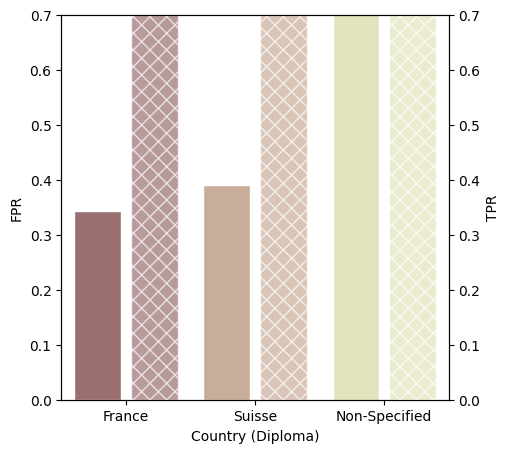

In [31]:
country_df['TPR'] = [np.round(equalized_odds(demographics[demographics['country_diploma'] == 'France'])[0], 3), 
                    np.round(equalized_odds(demographics[demographics['country_diploma'] == 'Suisse'])[0], 3),
                    np.round(equalized_odds(demographics[demographics['country_diploma'].isna()])[0], 3)]
country_df['FPR'] = [np.round(equalized_odds(demographics[demographics['country_diploma'] == 'France'])[1], 3), 
                    np.round(equalized_odds(demographics[demographics['country_diploma'] == 'Suisse'])[1], 3),
                    np.round(equalized_odds(demographics[demographics['country_diploma'].isna()])[1], 3)]
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='Country (Diploma)', y='FPR', data=country_df, palette = 'pink', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='Country (Diploma)', y='TPR', data=country_df, palette = 'pink', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

plt.show()

In [32]:
country_df[['Country (Diploma)', 'TPR', 'FPR']][:-1]

,Country (Diploma),TPR,FPR
0,France,0.806,0.344
1,Suisse,0.780,0.391


#### Combined Attributes

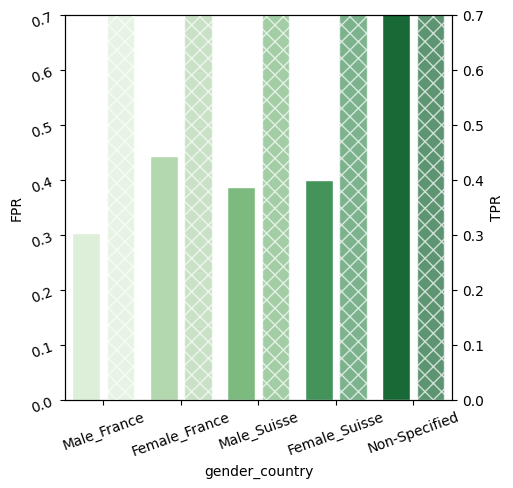

In [33]:
combined_df['TPR'] = [
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'M')])[0], 3), 
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'F')])[0], 3), 
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'M')])[0], 3), 
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'F')])[0], 3), 
                    np.round(equalized_odds(demographics[demographics['country_diploma'].isna()])[0], 3), 
                    ]

combined_df['FPR'] = [
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'M')])[1], 3), 
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'F')])[1], 3), 
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'M')])[1], 3), 
                    np.round(equalized_odds(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'F')])[1], 3), 
                    np.round(equalized_odds(demographics[demographics['country_diploma'].isna()])[1], 3), 
                    ]
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='gender_country', y='FPR', data=combined_df, palette = 'Greens', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='gender_country', y='TPR', data=combined_df, palette = 'Greens', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

ax.tick_params(labelrotation=20)
plt.show()

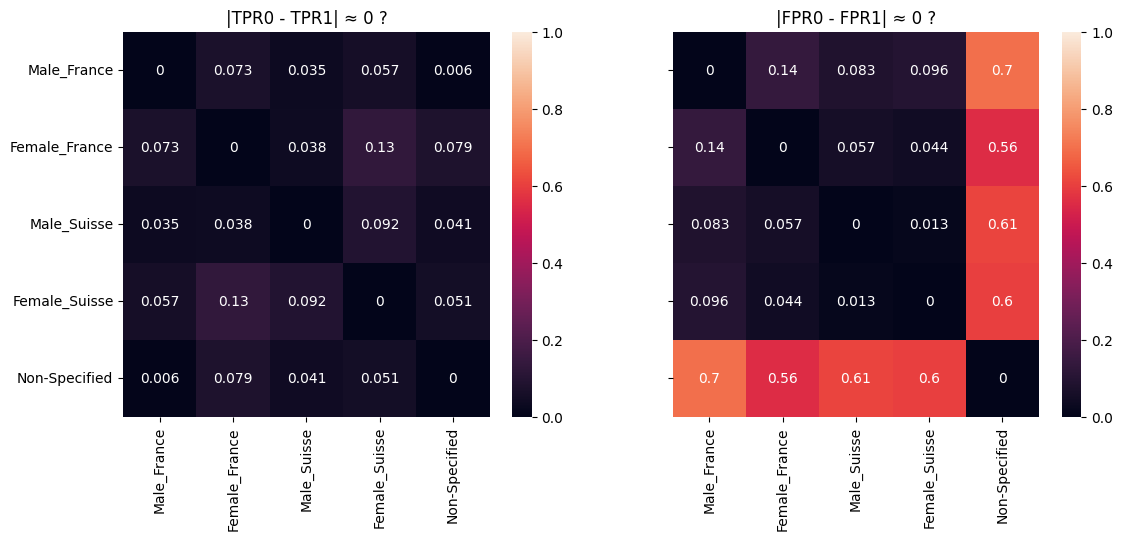

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3), stat='TPR')
sns.heatmap(heatmap, ax=ax[0], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[0].set_title("|TPR0 - TPR1| ≈ 0 ?")

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3), stat='FPR')
sns.heatmap(heatmap, ax=ax[1], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[1].set_title("|FPR0 - FPR1| ≈ 0 ?")

plt.show()

## Fairness Definition 3: Disparate Impact

Our third definition of fairness is disparate impact (DI). We start by calculating the PPP rates seen below. This is the percentage of people who have either been correctly (TP) or incorrectly (FP) predicted as positive. We can interpret this as the percentage of people who will benefit from the model.

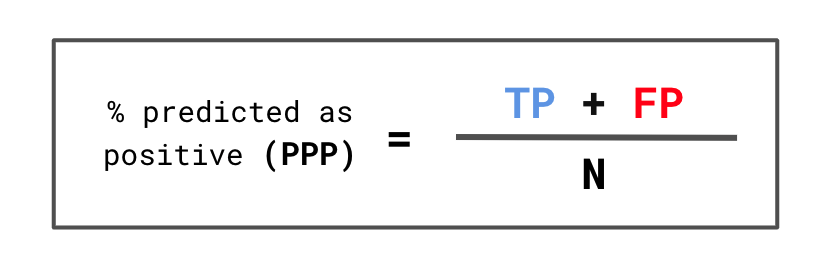

Under DI we consider a model to be fair if we have equal PPP rates. Again, in practice, we use a cutoff to give some leeway. This definition is supposed to represent the legal concept of disparate impact. In the US there is a legal precedent to set the cutoff to 0.8. That is the PPP for the unprivileged group must not be less than 80% of that of the privileged group.

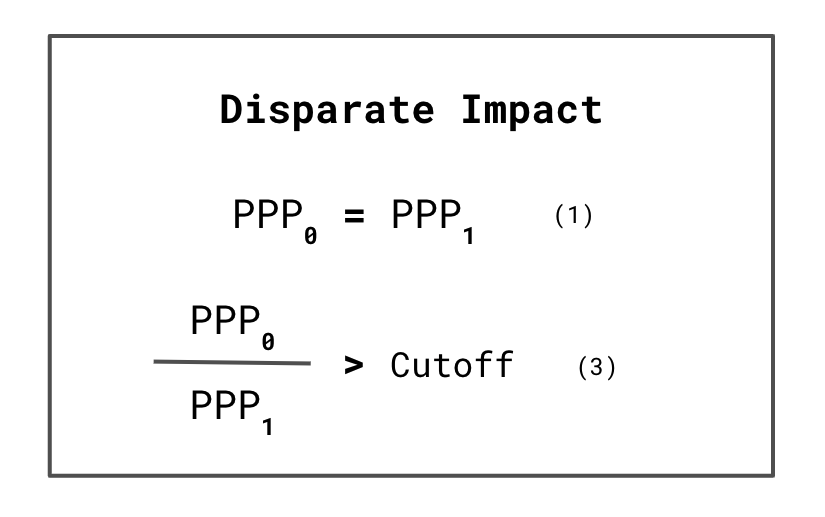

In [35]:
def disparate_impact(df):
    """Calculate PPP for subgroup of population"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Total population
    N = TP + FP + FN + TN 
    
    # predicted as positive
    PPP = (TP + FP) / N 
    
    return PPP

In [36]:
print("Overall PPP:", np.round(disparate_impact(demographics), 3))

Overall PPP: 0.64


#### Sensitive Attribute: Gender

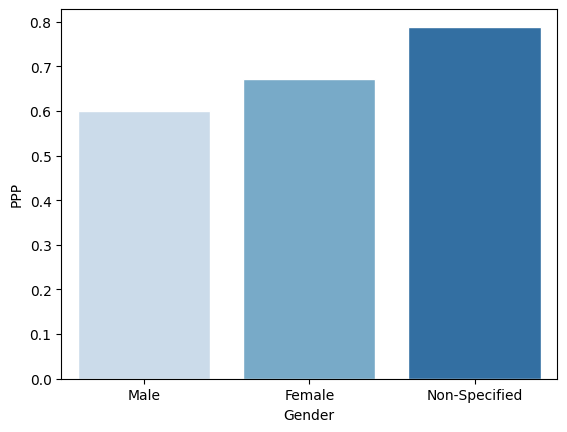

In [37]:
gender_df['PPP'] = [np.round(disparate_impact(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(disparate_impact(demographics[demographics['gender'] == 'F']), 3),
                    np.round(disparate_impact(demographics[demographics['gender'].isna()]), 3)]
       
sns.barplot(x='Gender', y='PPP', data=gender_df, palette = 'Blues', edgecolor = 'w')
plt.show()

In [38]:
# For disparate impact, we compare the ratio between the PPPs of the sensitive attributes.
# We define our significance cutoff at 0.1, stating any difference below 10% can be attributed to random chance.

def stats_ppp(df, attr, cutoff=0.1):
    PPP_0, PPP_1 = df['PPP'][0], df['PPP'][1]
    ppp_ratio = np.round(np.minimum(PPP_0, PPP_1) / np.maximum(PPP_0, PPP_1), 3)
    
    print('Sensitive Attr:', attr, '\n')
    
    print('------------------------------------')
    print('Disparate Impact > Cutoff?', np.abs(ppp_ratio) > cutoff)
    print('------------------------------------')
    print('PPP0 (', df[attr][0], ') =', PPP_0)
    print('PPP1 (', df[attr][1], ') =', PPP_1)
    print('PPP_Ratio:', ppp_ratio)
    print('Cutoff:', cutoff)

stats_ppp(gender_df, 'Gender')

Sensitive Attr: Gender 

------------------------------------
Disparate Impact > Cutoff? True
------------------------------------
PPP0 ( Male ) = 0.6
PPP1 ( Female ) = 0.671
PPP_Ratio: 0.894
Cutoff: 0.1


#### Sensitive Attribute: Country (Diploma)

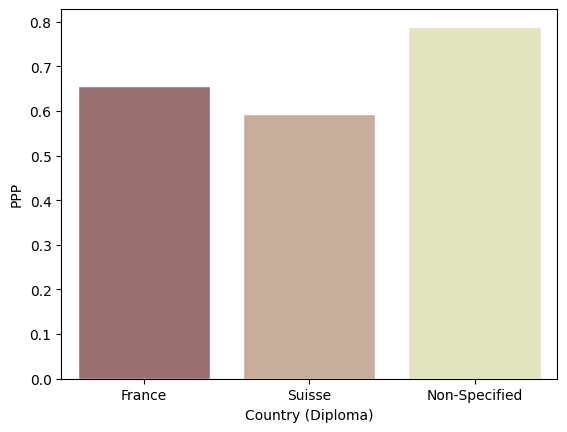

In [39]:
country_df['PPP'] = [np.round(disparate_impact(demographics[demographics['country_diploma'] == 'France']), 3), 
                    np.round(disparate_impact(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                    np.round(disparate_impact(demographics[demographics['country_diploma'].isna()]), 3)]

       
sns.barplot(x='Country (Diploma)', y='PPP', data=country_df, palette = 'pink', edgecolor = 'w')
plt.show()

In [40]:
stats_ppp(country_df, 'Country (Diploma)')

Sensitive Attr: Country (Diploma) 

------------------------------------
Disparate Impact > Cutoff? True
------------------------------------
PPP0 ( France ) = 0.657
PPP1 ( Suisse ) = 0.594
PPP_Ratio: 0.904
Cutoff: 0.1


#### Combined Attributes

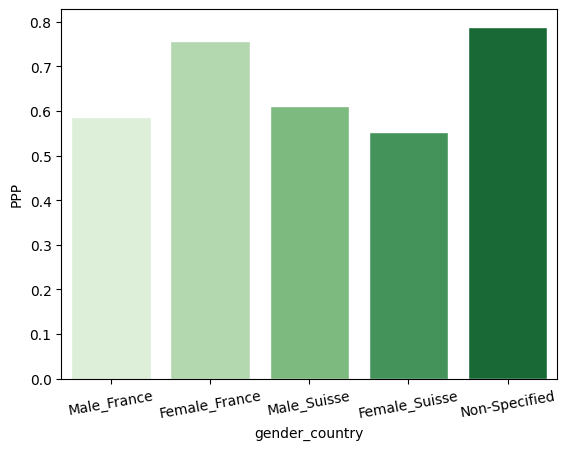

In [41]:
combined_df['PPP'] = [
                    np.round(disparate_impact(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'M')]), 3), 
                    np.round(disparate_impact(demographics[(demographics['country_diploma'] == 'France') & 
                                                            (demographics['gender'] == 'F')]), 3), 
                    np.round(disparate_impact(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'M')]), 3), 
                    np.round(disparate_impact(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                            (demographics['gender'] == 'F')]), 3), 
                    np.round(disparate_impact(demographics[demographics['country_diploma'].isna()]), 3), 
                    ]

       
sns.barplot(x='gender_country', y='PPP', data=combined_df, palette = 'Greens', edgecolor = 'w')
plt.xticks(rotation=10)
plt.show()

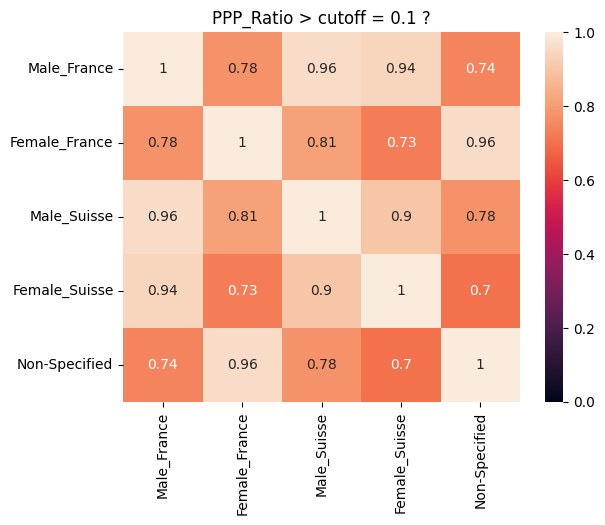

In [42]:
heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.minimum(x[0], x[1]) / np.maximum(x[0], x[1]), 3), stat='PPP')
sns.heatmap(heatmap, xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
plt.title("PPP_Ratio > cutoff = 0.1 ?")
plt.show()

## Fairness Definition 4: Demographic Parity

**Demographic Parity** states that the proportion of each segment of a protected class (e.g. gender) should receive the positive outcome at equal rates. A positive outcome is the preferred decision, such as in our case, passing a class. 

*Demographic Parity is very similar to Disparate Impact*, with the only difference being that it measures the difference between PPPs instead of the ratio.

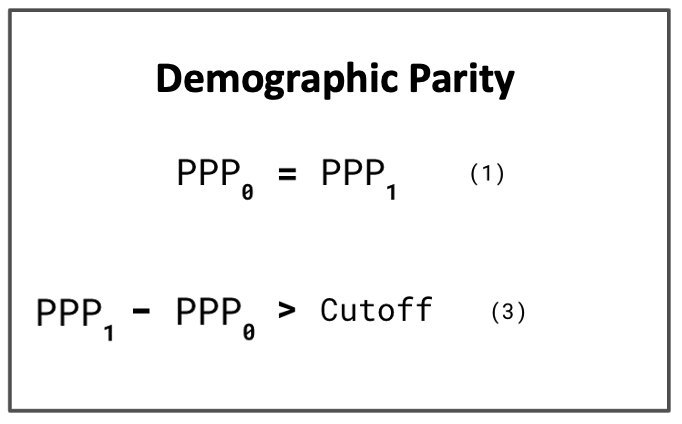

In [43]:
# For demographic parity, we compare the difference between the PPPs of the sensitive attributes.
# We define our significance cutoff at 0.1, stating any difference below 10% can be attributed to random chance.

def stats_dp(df, attr, cutoff=0.1):
    PPP_0, PPP_1 = df['PPP'][0], df['PPP'][1]
    ppp_diff = np.round(np.abs(PPP_1 - PPP_0), 3)
    
    print('Sensitive Attr:', attr, '\n')
    
    print('------------------------------------')
    print('|Demographic Parity| > Cutoff?', np.abs(ppp_diff) > cutoff)
    print('------------------------------------')
    print('PPP0 (', df[attr][0], ') =', PPP_0)
    print('PPP1 (', df[attr][1], ') =', PPP_1)
    print('PPP_Diff:', ppp_diff)
    print('Cutoff:', cutoff)

stats_dp(gender_df, 'Gender')

Sensitive Attr: Gender 

------------------------------------
|Demographic Parity| > Cutoff? False
------------------------------------
PPP0 ( Male ) = 0.6
PPP1 ( Female ) = 0.671
PPP_Diff: 0.071
Cutoff: 0.1


In [44]:
stats_dp(country_df, 'Country (Diploma)')

Sensitive Attr: Country (Diploma) 

------------------------------------
|Demographic Parity| > Cutoff? False
------------------------------------
PPP0 ( France ) = 0.657
PPP1 ( Suisse ) = 0.594
PPP_Diff: 0.063
Cutoff: 0.1


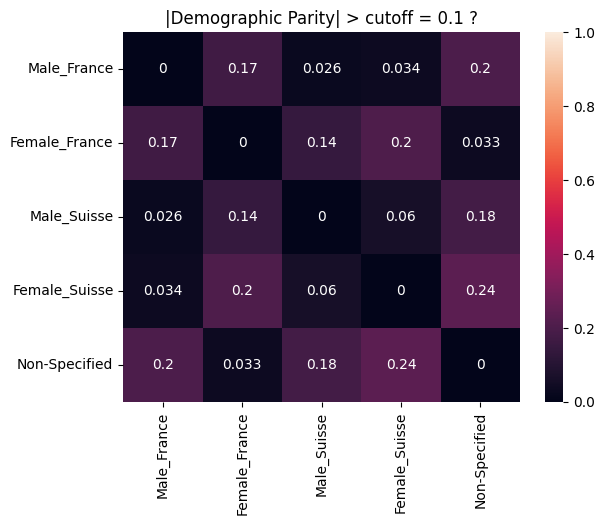

In [45]:
heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3), stat='PPP')
sns.heatmap(heatmap, xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
plt.title("|Demographic Parity| > cutoff = 0.1 ?")
plt.show()

## Fairness Definition 5: Predictive Value Parity

Predictive value-parity equalizes the chance of success, given a positive prediction (PPV) or negative prediction (NPV).

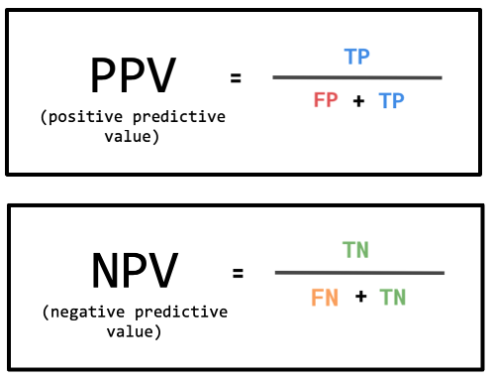

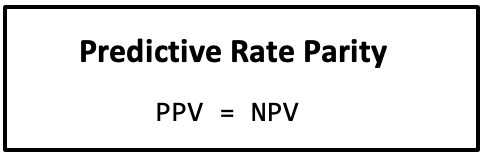

In [46]:
def predictive_value_parity(df):
    """Calculate predictive value parity scores"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Positive Predictive Value
    PPV = TP / (FP + TP) 
    
    # Negative Predictive Value
    NPV = TN / (FN + TN) 
    
    return [PPV, NPV]

In [47]:
print("Overal PPV:", np.round(predictive_value_parity(demographics)[0], 3))
print("Overal NPV:", np.round(predictive_value_parity(demographics)[1], 3))

Overal PPV: 0.774
Overal NPV: 0.636


#### Sensitive Attribute: Gender

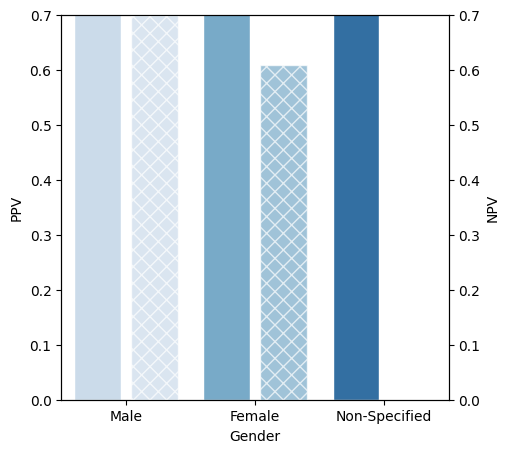

In [48]:
gender_df['PPV'] = [np.round(predictive_value_parity(demographics[demographics['gender'] == 'M'])[0], 3), 
                    np.round(predictive_value_parity(demographics[demographics['gender'] == 'F'])[0], 3),
                    np.round(predictive_value_parity(demographics[demographics['gender'].isna()])[0], 3)]

gender_df['NPV'] = [np.round(predictive_value_parity(demographics[demographics['gender'] == 'M'])[1], 3), 
                    np.round(predictive_value_parity(demographics[demographics['gender'] == 'F'])[1], 3),
                    np.round(predictive_value_parity(demographics[demographics['gender'].isna()])[1], 3)]
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='Gender', y='PPV', data=gender_df, palette = 'Blues', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='Gender', y='NPV', data=gender_df, palette = 'Blues', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

plt.show()

In [49]:
gender_df[['Gender', 'PPV', 'NPV']][:-1]

,Gender,PPV,NPV
0,Male,0.747,0.700
1,Female,0.787,0.609


#### Sensitive Attribute: Country (Diploma)

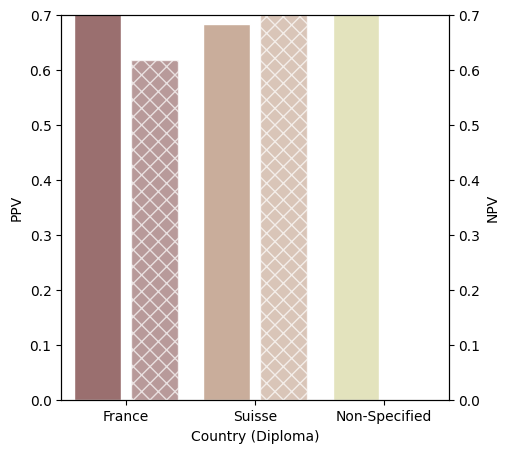

In [50]:
country_df['PPV'] = [np.round(predictive_value_parity(demographics[demographics['country_diploma'] == 'France'])[0], 3), 
                    np.round(predictive_value_parity(demographics[demographics['country_diploma'] == 'Suisse'])[0], 3),
                    np.round(predictive_value_parity(demographics[demographics['country_diploma'].isna()])[0], 3)]
country_df['NPV'] = [np.round(predictive_value_parity(demographics[demographics['country_diploma'] == 'France'])[1], 3), 
                    np.round(predictive_value_parity(demographics[demographics['country_diploma'] == 'Suisse'])[1], 3),
                    np.round(predictive_value_parity(demographics[demographics['country_diploma'].isna()])[1], 3)]
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='Country (Diploma)', y='PPV', data=country_df, palette = 'pink', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='Country (Diploma)', y='NPV', data=country_df, palette = 'pink', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

plt.show()

In [51]:
country_df[['Country (Diploma)', 'PPV', 'NPV']][:-1]

,Country (Diploma),PPV,NPV
0,France,0.831,0.618
1,Suisse,0.684,0.718


#### Sensitive Attribute: Combine

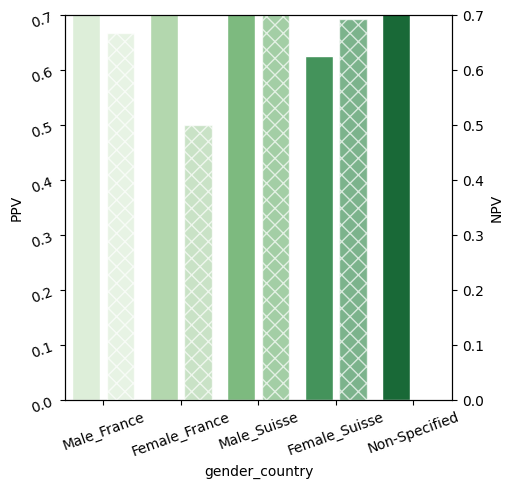

In [52]:
combined_df['PPV'] = [
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'France') & 
                                                                (demographics['gender'] == 'M')])[0], 3), 
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'France') & 
                                                                (demographics['gender'] == 'F')])[0], 3), 
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                                (demographics['gender'] == 'M')])[0], 3), 
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                                (demographics['gender'] == 'F')])[0], 3), 
                    np.round(predictive_value_parity(demographics[demographics['country_diploma'].isna()])[0], 3), 
                    ]

combined_df['NPV'] = [
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'France') & 
                                                                (demographics['gender'] == 'M')])[1], 3), 
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'France') & 
                                                                (demographics['gender'] == 'F')])[1], 3), 
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                                (demographics['gender'] == 'M')])[1], 3), 
                    np.round(predictive_value_parity(demographics[(demographics['country_diploma'] == 'Suisse') & 
                                                                (demographics['gender'] == 'F')])[1], 3), 
                    np.round(predictive_value_parity(demographics[demographics['country_diploma'].isna()])[1], 3), 
                    ]
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='gender_country', y='PPV', data=combined_df, palette = 'Greens', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='gender_country', y='NPV', data=combined_df, palette = 'Greens', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

ax.tick_params(labelrotation=20)
plt.show()

In [53]:
combined_df[['gender_country', 'PPV', 'NPV']][:-1]

,gender_country,PPV,NPV
0,Male_France,0.794,0.667
1,Female_France,0.871,0.500
2,Male_Suisse,0.707,0.731
3,Female_Suisse,0.625,0.692


### Interpretations

##### Country Attribute

We can see that in the Accuracy, Equal Opportunity (TPR) and Disparate Impact (PPP) metrics, the France category is greater than the Suisse category. 
However, they have close enough TPR/FRP to have Equalized Odds. 

Also, the PPP_Ratio is bigger than the cutoff, and we have Demographic Parity since the difference between France and Suisse are smaller than the cutoff. 

However, in the France category, there is a significance difference between PPV and NPV values, which show us that there is no Predictive Rate Parity.

##### Combined Attributes

Now looking at the Combined Attributes, we can see a significant difference in accuracy between Female_France and Female_Suisse. 

We also see this difference in TPR leading to an Equal Opportunity bigger than the cutoff. For equalized odds, the difference in FPR between Female_France and Female_Suisse is very small, but still apparent. We cannot say that they have Equalized odds. 

Conversely, looking at Male_France and Female_France, the difference in TPR is small but not in FPR. 

For Disparate Impact, we see a significant difference in PPP between Female_France and Female_Suisse, although the ratio is bigger than the cutoff. 

The main difference with the Gender/Country individual analyses vs. the combined subgroup analysis is when we see result from the Demographic Parity. A majority of |Demographic Parity| values are bigger than the cutoff. This can be caused by the different sizes of each category, as seen at the beginning of the notebook. 

Lastly, regarding Predictive Value Parity, we have a significant difference between PPV and NPV in both Male_France and Female_France category, meaning that they don't have an equal chance of success given a positive or negative prediction. This disparity didn't exist in the individual analysis, which is why it is very important to run combined attribute analyses for fairness.

### Fairness Metrics (Overall)

In [54]:
gender_df

,Gender,ACC,TPR,FNR,FPR,PPP,PPV,NPV
0,Male,0.728,0.789,0.211,0.352,0.600,0.747,0.700
1,Female,0.729,0.804,0.196,0.417,0.671,0.787,0.609
2,Non-Specified,0.684,0.765,0.235,1.000,0.789,0.867,0.000


In [55]:
country_df

,Country (Diploma),ACC,TPR,FNR,FPR,PPP,PPV,NPV
0,France,0.758,0.806,0.194,0.344,0.657,0.831,0.618
1,Suisse,0.698,0.780,0.220,0.391,0.594,0.684,0.718
2,Non-Specified,0.684,0.765,0.235,1.000,0.789,0.867,0.000


In [56]:
combined_df

,gender_country,ACC,TPR,FNR,FPR,PPP,PPV,NPV
0,Male_France,0.741,0.771,0.229,0.304,0.586,0.794,0.667
1,Female_France,0.780,0.844,0.156,0.444,0.756,0.871,0.500
2,Male_Suisse,0.716,0.806,0.194,0.387,0.612,0.707,0.731
3,Female_Suisse,0.655,0.714,0.286,0.400,0.552,0.625,0.692
4,Non-Specified,0.684,0.765,0.235,1.000,0.789,0.867,0.000
